# Random Reattachment of Fragment Species from Automatic Fragment Modeling (AFM) Simulation Results
AFM allows users to construct mechanisms for large molecules with RMG by breaking them up into two or more fragments. Running simulations with a fragment mechanism is much the same as any other mechanism. However, the species profiles obtained are for individual fragments that may be attached in many combinations. In this notebook, we give an example of random reattachment of fragments produced from polymer pyrolysis, which allows the user to obtain important observables such as molecular weight distribution or the approximate concentration of specific species composed of multiple fragments.

In [1]:
import sys
rmgpy_loc = "/home/gridsan/adoner/RMG-Py/"
sys.path.append(rmgpy_loc)
from rmgpy.molecule.fragment import Fragment
from rmgpy.tools.canteramodel import Cantera
from rmgpy.chemkin import load_chemkin_file
from rmgpy.molecule.fragment_utils import match_sequences, match_concentrations_with_same_sums, match_concentrations_with_different_sums, shuffle, flatten, merge_frag_to_frag, merge_frag_list
import re
import os
import numpy as np
import matplotlib.pyplot as plt


## Defining the class FragList
The `FragList` object stores molecule and fragment concentrations from a single time step and provides a series of functions that groups fragments to form molecules. The procedure is described later on in this notebook.

In [2]:
class FragList():
    '''
    to instantiate a FragList:
    fl = Fraglist(frag_list)
    where frag_list is a list of tuples of fragments and their amounts
    '''

    def __init__(self, frag_list):
        self.raw_fragment_output = frag_list

    def sort(self):
        '''
        sort a FragList into
            general_R_list - 2R fragments
            general_L_list - 2L fragments
            rr_ll_list - 2R or 2L fragments
            r_l_moles - 1R and 1L fragments
            multi_label_frag_3 - fragments with 3 cutting labels
            multi_label_frag_4 - fragments with 4 cutting labels

            note: in our experience fragments with more than 4 cutting labels has never happened, but a warning will be printed if it does happen
        '''
        moles_remain = []
        one_R_dict = {}
        one_L_dict = {}
        general_R_list = []
        general_L_list = []
        rr_ll_list = []
        r_l_moles = []
        multi_label_frag_3 = []
        multi_label_frag_4 = []

        for i, item in enumerate(self.raw_fragment_output):
            frag, amt = item
            if amt > 1e-6 and '[' not in frag:
                count_of_L_labels = len(re.findall(r'L', frag))
                count_of_R_labels = len(re.findall(r'R', frag))
                count_of_cutting_labels = count_of_L_labels + count_of_R_labels
                if count_of_R_labels == 0 and count_of_L_labels == 0:
                    moles_remain.append((frag, amt))
                elif count_of_R_labels == 1 and count_of_L_labels == 0:
                    one_R_dict[frag] = amt
                elif count_of_R_labels == 2 and count_of_L_labels == 0:
                    general_R_list.append((frag, amt * 2))
                    rr_ll_list.append(frag)
                elif count_of_R_labels == 0 and count_of_L_labels == 1:
                    one_L_dict[frag] = amt
                elif count_of_R_labels == 0 and count_of_L_labels == 2:
                    general_L_list.append((frag, amt * 2))
                    rr_ll_list.append(frag)
                elif count_of_R_labels == 1 and count_of_L_labels == 1:
                    r_l_moles.append((frag, amt))
                else:
                    if count_of_cutting_labels == 3:
                        multi_label_frag_3.append(
                            (frag, amt))  # 2R1L, 1R2L, 3R, 3L
                    elif count_of_cutting_labels == 4:
                        multi_label_frag_4.append((frag, amt))
                    else:
                        print(
                            f"Warning! {count_of_cutting_labels} cutting labels in {frag}")
        self.R1dict=one_R_dict
        self.L1dict=one_L_dict
        self.Rlist=general_R_list
        self.Llist=general_L_list
        self.RRLLlist=rr_ll_list
        self.RLlist=r_l_moles
        self.CL3=multi_label_frag_3
        self.CL4=multi_label_frag_4
        self.molesremain=moles_remain

    def random_pick_frag(target_dict):
        '''
        argument(s): target_dict - dictionary where key = species smiles (fragment or molecule), value = moles
        returns: tuple of randomly picked (fragment with 1 cutting label, moles)

        choice is weighted by mole fraction of each fragment
        '''
        import random
        import re
        frag_dict_list=[x for x in target_dict.items() if len(
            re.findall(r'[LR]', x[0])) == 1]
        sum_dict=sum([x[1] for x in frag_dict_list])
        frag_dict_prob=[x[1] / sum_dict for x in frag_dict_list]
        item=np.random.choice(frag_dict_list, 1, p = frag_dict_prob)

        return item

    def pair_frag(amount, target_dict):
        '''
        argument(s): amount - maximum amount of fragments in one pair
                    target_dict - dictionary of species smiles and moles
        returns: the target_dict with 1 randomly chosen 1-cutting label fragment fully paired with other randomly chosen 1-cutting label fragments
        '''
        additional_frag_list=[]
        frag1=FragList.random_pick_frag(target_dict)

        if target_dict[frag1] >= amount:
            target_dict[frag1] -= amount
            additional_frag_list.append((frag1, amount))

        else:
            remain=amount - target_dict[frag1]
            additional_frag_list.append((frag1, amount))
            target_dict[frag1]=0

            while remain > 0:
                frag1=FragList.random_pick_frag(target_dict)

                if target_dict[frag1] >= remain:
                    target_dict[frag1] -= remain
                    additional_frag_list.append((frag1, remain))
                    remain=0

                else:
                    frag_amt=target_dict[frag1]
                    target_dict[frag1]=0
                    additional_frag_list.append((frag1, frag_amt))
                    remain=remain - frag_amt
        return additional_frag_list

    def pair_CL4s(self):
        '''
        pairs all 4-cutting label fragments with other randomly picked 1-cutting label fragments, creating 3-cutting label fragments
        '''

        for species, amount in self.CL4:  # 4R, 3R1L, 2R2L, 1R3L, 4L
            ount_of_R_labels=len(re.findall(r'R', species))
            count_of_L_labels=len(re.findall(r'L', species))
            if count_of_R_labels == 4 and count_of_L_labels == 0:
                paired_frag_list=FragList.pair_frag(amount, self.L1dict)
                for frag_amt in paired_frag_list:
                    frag=frag_amt[0]
                    amt=frag_amt[1]
                    frag1=frag  # 1L
                    frag2=species  # 4R
                    frag_new=FragList.merge_frag_to_frag(frag1, frag2, 'R')  # L,R,R -> 3
                    self.CL3.append((frag_new, amt))

            elif count_of_R_labels == 0 and count_of_L_labels == 4:
                paired_frag_list = FragList.pair_frag(amount, self.R1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1R
                    frag2 = species  # 4L
                    frag_new = FragList.merge_frag_to_frag(frag2, frag1, 'R')  # L,R,R -> 3L
                    self.CL3.append((frag_new, amt))

            elif count_of_R_labels == 2 and count_of_L_labels == 2:
                paired_frag_list = FragList.pair_frag(amount, self.L1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1L
                    frag2 = species  # 2R2L
                    frag_new = FragList.merge_frag_to_frag(frag1, frag2, 'R')  # L,R,R -> 1R2L
                    self.CL3.append((frag_new, amt))

            elif count_of_R_labels == 3 and count_of_L_labels == 1:
                paired_frag_list = FragList.pair_frag(amount, self.R1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1R
                    frag2 = species  # 3R1L
                    frag_new = FragList.merge_frag_to_frag(frag2, frag1, 'R')  # L,R,R -> 3R
                    self.CL3.append((frag_new, amt))

            elif count_of_R_labels == 1 and count_of_L_labels == 3:
                paired_frag_list = FragList.pair_frag(amount, self.L1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1L
                    frag2 = species  # 1R3L
                    frag_new = FragList.merge_frag_to_frag(frag1, frag2, 'R')  # L,R,R -> 3L
                    self.CL3.append((frag_new, amt))

    def pair_CL3s(self):
        '''
        pairs all 3-cutting label fragments with other randomly picked 1-cutting label fragments, creating 2-cutting label fragments
        '''

        for species, amount in self.CL3:
            count_of_R_labels = len(re.findall(r'R', species))
            count_of_L_labels = len(re.findall(r'L', species))
            if count_of_R_labels == 2 and count_of_L_labels == 1:
                paired_frag_list = FragList.pair_frag(amount, self.R1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1R
                    frag2 = species  # 2R1L
                    frag_new = FragList.merge_frag_to_frag(frag2, frag1, 'R')  # L,R,R
                    self.Rlist.append((frag_new, amt * 2))
                    self.RRLLlist.append(frag_new)

            elif count_of_R_labels == 1 and count_of_L_labels == 2:
                paired_frag_list = FragList.pair_frag(amount, self.L1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1L
                    frag2 = species  # 1R2L
                    frag_new = FragList.merge_frag_to_frag(frag1, frag2, 'R')  # L,R,R
                    self.Llist.append((frag_new, amt * 2))
                    self.RRLLlist.append(frag_new)

            elif count_of_R_labels == 3 and count_of_L_labels == 0:
                paired_frag_list = FragList.pair_frag(amount, self.L1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1L
                    frag2 = species  # 3R
                    frag_new = FragList.merge_frag_to_frag(frag1, frag2, 'R')  # L,R,R
                    self.Rlist.append((frag_new, amt * 2))
                    self.RRLLlist.append(frag_new)

            # 3L
            elif count_of_R_labels == 0 and count_of_L_labels == 3:
                paired_frag_list = FragList.pair_frag(amount, self.R1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1R
                    frag2 = species  # 3L
                    frag_new = FragList.merge_frag_to_frag(frag2, frag1, 'R')  # L,R,R
                    self.Llist.append((frag_new, amt * 2))
                    self.RRLLlist.append(frag_new)

    def update_lists(self):
        '''
        adds the 1-cuttinglabel fragments remaining after pairing 4- and 3-cutting label fragments to their corresponding list
        '''
        for one_R_frag, amt in self.R1dict.items():
            self.Rlist.append((one_R_frag, amt))
        for one_L_frag, amt in self.L1dict.items():
            self.Llist.append((one_L_frag, amt))

    def grind(conc, size):
        '''
        Split fragment concentrations into several repeating concentration units with specified size
        '''
        grinded_conc = []
        for label, c in conc:
            times = int(c / size)
            grinded_conc.extend([(label, size)] * times)

            if c - size * times > 0:
                grinded_conc.append((label, c - size * times))

        return grinded_conc


    def grind_endcaps(self, grindsize=1, repeats=1):
        '''
        splits each fragment concentration in to many subconcentrations of a maximum of grindsize
        '''
        print('grinding endcaps to {}'.format(grindsize))
        self.repeats = repeats
        if self.repeats == 1:
            self.grindsize = grindsize
            seed = np.random.randint(0, 100)
            grmoles = FragList.grind(self.Rlist, self.grindsize)
            glmoles = FragList.grind(self.Llist, self.grindsize)
            self.glmoles = shuffle(glmoles, seed)
            self.grmoles = shuffle(grmoles, seed+1)
        else:
            print('repeats > 1 not supported')

    def pair_endcaps(self):
        '''
        randomly pairs subconcentrations of endcaps and assigns the correct amount for each pair
        2L and 2R fragments will be paired with 2 1-cuttinglabel fragments
        the remaining fragment subconcentrations are middle pieces
        '''
        matches = match_concentrations_with_same_sums(self.glmoles,
                                                               self.grmoles,
                                                               rtol=1e-3)
        self.endcaps = []
        self.middles = []
        for match in matches:
            pair = match[0]
            value = match[1]
            if value > 0.0:
                lfrag, rfrag = pair
                if lfrag not in self.RRLLlist:
                    if rfrag not in self.RRLLlist:
                        self.endcaps.append((pair, value))
                    elif rfrag in self.RRLLlist:
                        self.endcaps.append(((lfrag, rfrag, lfrag), value/2))
                    else:
                        raise Error
                elif lfrag in self.RRLLlist:
                    if rfrag not in self.RRLLlist:
                        self.endcaps.append(((rfrag, lfrag, rfrag), value/2))
                    elif rfrag in self.RRLLlist:
                        self.middles.append((pair, value/2))
                    else:
                        raise Error
                else:
                    raise Error

    def grind_middles(self):
        '''
        grinds the middle 1L1R fragments into subconcentrations
        the same grindsize is used as for the endcaps
        '''
        print('grinding middle pieces to {}'.format(self.grindsize))
        if self.repeats == 1:
            grinded_r_l_moles = FragList.grind(self.RLlist, self.grindsize)
            seed = np.random.randint(0, 100)
            self.middles = self.middles + \
                shuffle(grinded_r_l_moles, seed)
        else:
            print('repeats > 1 not supported')

    def distribute_middles(self):
        '''
        loop through the middle pieces
        randomly pick an endcap pair to add to
        repeat until no more middle pieces 
        '''
        import random
        sys.setrecursionlimit(15000)
        r_l_frag_distri_amt = [0 for i in range(len(self.endcaps))]
        r_l_frag_distri_dict = [{} for i in range(len(self.endcaps))]
        for i, r_l_tup in enumerate(self.middles):
            r_l_frag = r_l_tup[0]
            r_l_frag_amount = r_l_tup[1]
            rand_idx = random.randrange(len(self.endcaps))
            threshold = 1e-15
            while self.endcaps[rand_idx][1] <= threshold:
                rand_idx = random.randrange(len(self.endcaps))
            r_l_frag_distri_amt[rand_idx] += r_l_frag_amount
            r_l_dict = r_l_frag_distri_dict[rand_idx]
            if r_l_frag in r_l_dict.keys():
                r_l_dict[r_l_frag] += r_l_frag_amount
            else:
                r_l_dict[r_l_frag] = r_l_frag_amount
        matches_random = []
        for i in range(len(self.endcaps)):
            pair = self.endcaps[i]
            if r_l_frag_distri_dict[i].keys():
                r_l_matched = []
                for r_l_frag, amt in r_l_frag_distri_dict[i].items():
                    r_l_matched.append((r_l_frag, amt))
                match_list = match_concentrations_with_different_sums([
                                                                               pair], r_l_matched)
                for tups in match_list:
                    matches_random.append(tups)
            else: 
                matches_random.append(pair)
        flattened_matches_random = [
            (tuple(flatten(m[0])), m[1]) for m in matches_random]

        self.grouped = []

        for non_cut_mole, val in self.molesremain:
            self.grouped.append(((non_cut_mole, ), val))

        self.grouped.extend(flattened_matches_random)

    def get_mwd(self, bins=10, fname='mwd.png'):
        '''
        loop through molecules i.e. grouped fragments
        calculate molecular weight
        create histogram of molecular weights, weighted by molar amount
        store histogram data in histdata
        '''
        self.mwd_amts = [x[1] for x in self.grouped]
        self.mwd_mws = []
        for fraglist, amt in self.grouped:
            mw = sum([Fragment().from_smiles_like_string(
                frag).get_molecular_weight()*1000 for frag in fraglist])
            self.mwd_mws.append(mw)

        self.histdata = plt.hist(
            self.mwd_mws, bins=bins, weights=self.mwd_amts)
        plt.xlabel("Molecular Weight (g/mol)")
        plt.ylabel("Moles")

    def reattach(self, grindsize = 1):
        '''
        this parent function combines the steps of reattachment into one
        '''
        self.sort()  # sort the fragments by number and type of cutting labels
        self.pair_CL4s()  # reattach 4-cutting label fragments to make 3-cutting label fragments
        self.pair_CL3s()  # reattach 3-cutting label fragments to make 2-cutting label fragments
        self.update_lists()  # add 1-cutting label fragments to either Rlist or Llist
        self.grind_endcaps(grindsize=grindsize)  # grind the concentrations of fragments into smaller sub-concentrations
        self.pair_endcaps()  # pair together 1R and 1L fragments to make endcap pairs
        self.grind_middles()  # grind the concentrations of middle LR fragments into smaller sub-concentrations of same size as above
        self.distribute_middles()  # randomly select an endcap pair for each middle LR fragment
        return self



## 1. Set up the simulation...
- load the mechanism


In [3]:
working_dir = os.getcwd()
chemkin_path = os.path.join(working_dir, 'data/fragment_model/chem_annotated.inp')
species_dict_path = os.path.join(working_dir, 'data/fragment_model/species_dictionary.txt')
results_path = os.path.join(working_dir, 'results')
if not os.path.exists(results_path):
    os.mkdir(results_path)
species_list, reaction_list = load_chemkin_file(
    chemkin_path, species_dict_path)
species_dict = {}
for i, spe in enumerate(species_list):
    species_dict[spe.to_chemkin()] = spe

- specify starting species and conditions


In [4]:
RC10L = species_dict['RC10L(1)']
LC10 = species_dict['LC10(3)']
RC10 = species_dict['RC10(2)']
reactorTypeList = ['IdealGasConstPressureTemperatureReactor']
molFracList = [{RC10: 1,
                RC10L: 160,
                LC10: 1}]
Tlist = ([725.0], 'K')
Plist = ([1.0], 'bar')
# Vlist = ([1], 'm^3')
reactionTimeList = ([1], 'h')

- run the simulation

In [5]:
from rmgpy.tools.canteramodel import generate_cantera_conditions
job = Cantera(species_list=species_list,
              reaction_list=reaction_list, output_directory='temp_detailed')
job.load_model()
job.generate_conditions(reactorTypeList, reactionTimeList,
                        molFracList, Tlist=Tlist, Plist=Plist)
all_data = job.simulate()

(725.0, 'K')
(1.0, 'bar')
Reactor Type: IdealGasConstPressureTemperatureReactor
Reaction Time: 1 h
T0: 725 K
P0: 1 bar
Initial Mole Fractions: {'CC(C)CC(C)CC(C)CR': 0.006172839506172839, 'CC(L)CC(C)CC(C)CR': 0.9876543209876543, 'CC(C)CC(C)CC(C)CL': 0.006172839506172839}


- get the simulation results

In [6]:
time, dataList, _, _ = all_data[0]
T_data = np.array(dataList[0].data)
P_data = np.array(dataList[1].data)
V_data = np.array(dataList[2].data)
total_moles = P_data/8.314/T_data
total_moles_t0 = total_moles[0]
total_moles_tf = total_moles[-1]
T = Tlist[0][0]
t = reactionTimeList[0][0]

## 2. Random Reattachment Procedure
- make a list of tuples of each fragment species and its final concentration

In [7]:
moles_dict = {}  # key: Chemkin name of fragments, value: moles of fragsments at t_final
for i, mf in enumerate(dataList[6:]):
    spe = species_dict[mf.label].smiles
    moles_dict[spe] = max(mf.data[-1]*total_moles_tf, 0)
frag_list = list(moles_dict.items())

- The following steps describe the role of each function in the `FragList` class.

    1.  The `FragList` object is instantiated with the list of tuples made in the previous cell.

    2.  The `FragList.sort()` function categorizes the fragments by the number of cutting labels.

    3.  The `FragList.pair_CL4s()` function pairs fragments with 4 cutting labels with fragments with 1 cutting label to give fragments with 3 cutting labels.

    4.  The `FragList.pair_CL3s()` function pairs fragments with 3 cutting labels with fragments with 1 cutting label to give fragments with 2 cutting labels (either RR, RL, or LL fragments).

    5.  The `FragList.update_lists()` function adds any remainig fragments with one cutting label to a list of fragments with R cutting labels or a list of fragments with L cutting labels.

    6.  The `FragList.grind_endcaps()` function divides the fragments with 1 cutting label into smaller concentrations (no larger than the `grindsize` variable) to maximize the number of combinations.

    7.  The `FragList.pair_endcaps()` function pairs fragments with 2 of the same cutting label (e.g., LL and RR fragments) with a fragment with 1 cutting label. Then, each subconcentration of fragments with 1 R cutting label is randomly paired to a subconcentration of fragments with 1 L cutting label. These pairs will be the ends of the molecule.

    8.  The `FragList.grind_middles()` function divides the remaining fragments with 2 cutting labels (only LR fragments) into smaller concentrations (no larger than the `grindsize` variable) to maximize the number of combinations. 

    9.  The `FragList.distribute_middles()` function loops through all LR fragments and randomly assigns them to an endcap pair from step 7.

    10. the `FragList.get_mwd()` function plots the histogram of molecular weights of the reattached molecules generated in the previous steps and saves its data under the property `FragList.histdata`.
    
- Random reattachment will be repeated 10 times with a new random seed each time, which will allow us to examine the repeatability of reattachment.


grinding endcaps to 0.001
grinding middle pieces to 0.001
grinding endcaps to 0.001
grinding middle pieces to 0.001
grinding endcaps to 0.001
grinding middle pieces to 0.001


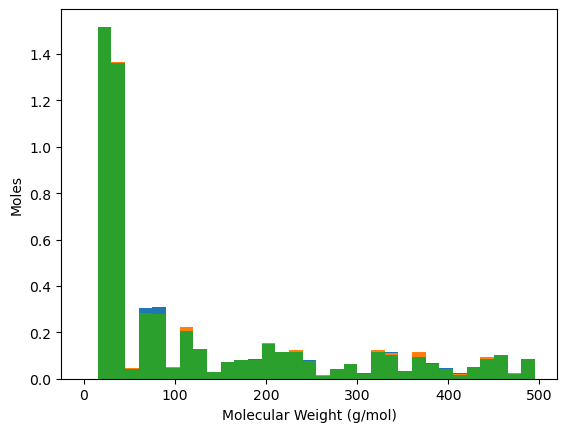

In [8]:
%matplotlib inline
hdl = []
hdl = []
for i in range(3):  
    fl = FragList(frag_list)
    fl.reattach(grindsize=0.001)
    fl.get_mwd(bins=range(0, 501, 15))
    hdl.append(fl.histdata)  # save histogram data for repeatability analysis

# 3. Analyze Data
- Examine repeatability of random reattachment by overlaying the 10 random reattachment trials from above

- Hint: If the repeatability is not satisfactory, try lowering the grindsize by an order of magnitude

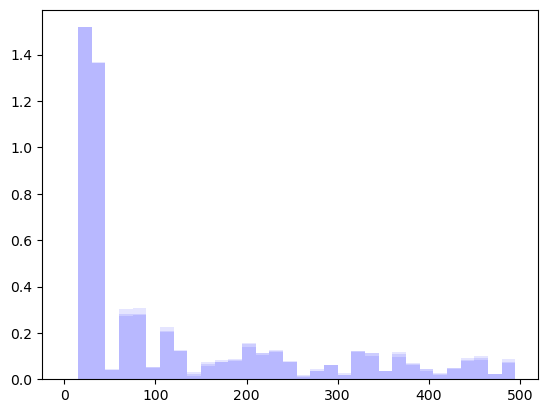

In [11]:
for hd in hdl:
    bins = hd[1]
    counts = hd[0]
    plt.hist(bins[:-1], bins, weights=counts, alpha=0.1, color='blue')

- List the molecules with the highest concentrations

In [10]:
results_dictionary = {}
for fraglist, amt in fl.grouped:
    fraglist = [Fragment().from_smiles_like_string(x) for x in fraglist]
    if len(fraglist) == 1:
        new = fraglist[0].smiles
    elif len(fraglist) < 6:
        new = merge_frag_list(fraglist)[0].smiles
    else:
        new = 'miscillaneous large molecules'
    if new in results_dictionary.keys():
        results_dictionary[new] += amt
    else:
        results_dictionary[new] = amt
sorted_rd = sorted(results_dictionary.items(), key=lambda x: x[1])[::-1]
total = sum([x[1] for x in sorted_rd])
print('species'.ljust(80), 'mole percent'.rjust(30))
for x, y in sorted_rd:
    print(str(x).ljust(80, '.') +
          str(str(np.round(y/total*100, 2))+'%').rjust(30, '.'))

species                                                                                            mole percent
C.......................................................................................................24.35%
C=CC....................................................................................................20.63%
miscillaneous large molecules.............................................................................8.8%
CCC......................................................................................................1.35%
C=CCCC...................................................................................................1.26%
C=CC=CC..................................................................................................1.25%
C=CCC(C)C=CC.............................................................................................1.08%
C=C(C)C=CC...............................................................................................0.81%
